In [2]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecMonitor, VecFrameStack, DummyVecEnv

from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import CheckpointCallback
import torch


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import imageio
import cv2
import numpy as np
import glob
import imageio

import sys
sys.path.append('../') #This is added so we can import from the source folder
from src.policies_modified import ImpalaCNN
from src.visualisation_functions import *



env_name = "procgen:procgen-heist-v0"  

env = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="easy") #remove render mode argument to go faster but not produce images 



ImportError: cannot import name 'run_episode_and_save_as_gif' from 'helpers' (/Users/bensturgeon/werk/ai-safety-camp-2024-model-agents/notebooks/helpers.py)

In [3]:
def load_model(env, model_path = '../model_1501.0_interpretable.pt'):
    observation_space = env.observation_space
    action_space = env.action_space.n
    model = ImpalaCNN(observation_space, action_space)
    model.load_from_file(model_path, device="cpu")
    return model

def run_episode_and_save_as_gif(env, model, filepath='../gifs/run.gif', save_gif=False, episode_timeout=2):

    observations = []
    observation = env.reset()
    done = False
    total_reward = 0
    frames=[]
    
    

    # observation = colour_swap(observation)
    count = 0
    while not done:
        if save_gif:
            frames.append(env.render(mode='rgb_array'))  
        print(observation.shape)
        action = generate_action(model, observation) 
        
        observation, reward, done, info = env.step(action)
        # observation = colour_swap(observation)
        total_reward += reward
        observations.append(observation)
        count +=1
        if count >= episode_timeout:
            break

    if save_gif:
        imageio.mimsave(filepath, frames, fps=30) 

    return total_reward, frames, observations

@torch.no_grad()
def generate_action(model, observation):
    observation = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)

    model_output = model(observation)
    
    logits = model_output[0].logits  # discard the output of the critic in our actor critic network
    
    probabilities = torch.softmax(logits, dim=-1)
    
    action = torch.multinomial(probabilities, 1).item() 
    return action


model = load_model(env)

save_gif_option = True  
for episode in range(1):
    env = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="easy") #remove render mode argument to go faster but not produce images 
    total_reward, frames, observations = run_episode_and_save_as_gif(env, model, filepath=f'episode_mod_2_{episode+1}.gif', save_gif=save_gif_option)
    print(f"Episode {episode + 1} finished with total reward: {total_reward}")



NameError: name 'env' is not defined

In [4]:
if frames:
    plt.imshow(frames[0])
    plt.title("First Frame of the Episode")
    plt.axis('off')  
    plt.show()
else:
    print("No frames captured.")

NameError: name 'frames' is not defined

In [5]:
# create gif of the episode
filename = "episode_gif.gif"
duration = 0.05
imageio.mimsave(filename, frames, duration=duration)

NameError: name 'frames' is not defined

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def swap_colours(observation):
    blue_key_colors = [
        [27, 177, 232],
        [20, 150, 198],
        [22, 161, 212]
    ]
    green_key_colors = [
        [125, 212, 70],
        [98, 189, 34],
        [110, 195, 56]
    ]

    # Create a copy of the observation array to modify
    modified_observation = observation.copy()

    # Swap the colors of blue and green keys
    for blue_color, green_color in zip(blue_key_colors, green_key_colors):
        # Find pixels that match the blue color within a tolerance
        blue_mask = np.abs(observation - blue_color).sum(axis=-1) < 65
        modified_observation[blue_mask] = green_color

        # Find pixels that match the green color within a tolerance
        green_mask = np.abs(observation - green_color).sum(axis=-1) < 65
        modified_observation[green_mask] = blue_color
        

    return observation

    

def plot_heist_observation(observation):
    # Define the colors to swap

    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))
    # Plot the modified observation
    ax.imshow(observation)

    # Remove the axis ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])

    # Display the plot
    plt.show()


def read_modified_image(filename):
    # Load the edited PNG image
    edited_image = cv2.imread(filename)

    # Resize the image to match the original observation dimensions
    resized_image = cv2.resize(edited_image, (64, 64))

    # Convert the color format if necessary
    if resized_image.shape[2] == 4:  # RGBA format
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_RGBA2RGB)
    elif resized_image.shape[2] == 1:  # Grayscale format
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB)

    resized_image = cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR)
    # Ensure the image data type matches the original observation
    resized_image = resized_image.astype(np.uint8)
    image_tensor = torch.from_numpy(resized_image)
    image_tensor =  image_tensor.unsqueeze(0)
    return image_tensor

In [119]:
activations = {}

def get_activation(name):
    def hook(model, input, output):
        # Initialize a placeholder for processed output
        processed_output = []
        
        for item in output:
            # Check if the item is a tensor and detach it
            if isinstance(item, torch.Tensor):
                processed_output.append(item.detach())
            # If the item is a Categorical, you might want to extract its logits or probs
            elif isinstance(item, torch.distributions.Categorical):
                processed_output.append(item.logits.detach())
            else:
                # Handle other types as necessary
                processed_output.append(item)
        
        # Save the processed output in the activations dictionary
        activations[name] = tuple(processed_output)
    return hook


model = load_model(env)

# Define a function to recursively register hooks based on a path
def register_hook_by_path(model, path, name):
    elements = path.split('.')
    for i, element in enumerate(elements):
        if '[' in element:
            # Splitting at '[' and removing the closing ']' to get the index
            base, index = element.replace(']', '').split('[')
            index = int(index)  # Convert index to integer
            model = getattr(model, base)[index]
        else:
            model = getattr(model, element)
        # If we are at the last element, register the hook
        if i == len(elements) - 1:
            model.register_forward_hook(get_activation(name))

# List of layer paths to hook, based on your initial list
layer_paths = [
    'conv_seqs.0.conv',
    'conv_seqs.0.res_block0.conv0',
    'conv_seqs.0.res_block0.conv1',
    'conv_seqs.0.res_block1.conv0',
    'conv_seqs.0.res_block1.conv1',
    'conv_seqs.1.conv',
    'conv_seqs.1.res_block0.conv0',
    'conv_seqs.1.res_block0.conv1',
    'conv_seqs.1.res_block1.conv0',
    'conv_seqs.1.res_block1.conv1',
    'conv_seqs.2.conv',
    'conv_seqs.2.res_block0.conv0',
    'conv_seqs.2.res_block0.conv1',
    'conv_seqs.2.res_block1.conv0',
    'conv_seqs.2.res_block1.conv1',
    # Add other layers as needed
]

# Register hooks for each path
for path in layer_paths:
    register_hook_by_path(model, path, path.replace('.', '_'))

# Run your data through the model
observation = torch.tensor(observations[0], dtype=torch.float32).unsqueeze(0)


output = model(observation)

# Now, activations['layer1'] contains the activations from layer1


In [124]:
import numpy as np
import math
import matplotlib.pyplot as plt

import numpy as np
import math
import matplotlib.pyplot as plt

def plot_layer_activations_dynamic_grid(activations, layer_name, save_filename=None, observation=None):
    if layer_name not in activations:
        print(f"No activations found for layer: {layer_name}")
        return

    # Extract the activation tensor for the specified layer
    activation_tensor = activations[layer_name][0].cpu().numpy()

    # Adjust for tensors that are 3D (missing batch dimension)
    if activation_tensor.ndim == 3:
        activation_tensor = activation_tensor[np.newaxis, :]  # Add a batch dimension

    # Determine the number of activation maps (filters) for this layer
    num_activations = activation_tensor.shape[1]

    # Calculate grid size, now adding 1 for the observation plot
    grid_size = math.ceil(math.sqrt(num_activations + 1))  # +1 for the observation

    # Create a figure with dynamic subplots based on the number of activations + 1 for observation
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2, grid_size * 2))

    # Plot observation first
    if observation is not None:
        # Assuming observation is already in the correct format for plotting
        obs_for_plot = observation.squeeze().numpy()
        axes[0, 0].imshow(obs_for_plot)
        axes[0, 0].set_title("Observation", fontsize=8)
        axes[0, 0].axis('off')
        start_idx = 1  # Start plotting activations from the next subplot
    else:
        start_idx = 0

    # Initialize an index for activation maps
    activation_idx = 0

    for i in range(grid_size):
        for j in range(grid_size):
            if i == 0 and j == 0 and observation is not None:
                continue  # Skip the first plot if it's used for the observation
            ax = axes[i, j]

            # Plot the activation map if we haven't gone through all of them yet
            if activation_idx < num_activations:
                ax.imshow(activation_tensor[0, activation_idx, :, :], cmap='viridis', aspect='auto')
                ax.set_title(f'Filter {activation_idx + start_idx}', fontsize=8)  # Adjust index if observation is plotted
                activation_idx += 1
            else:
                ax.axis('off')  # Hide axes without data

    plt.tight_layout()

    # Save or show the plot
    if save_filename:
        plt.savefig(save_filename)
        plt.close()
    else:
        plt.show()



KeyboardInterrupt: 

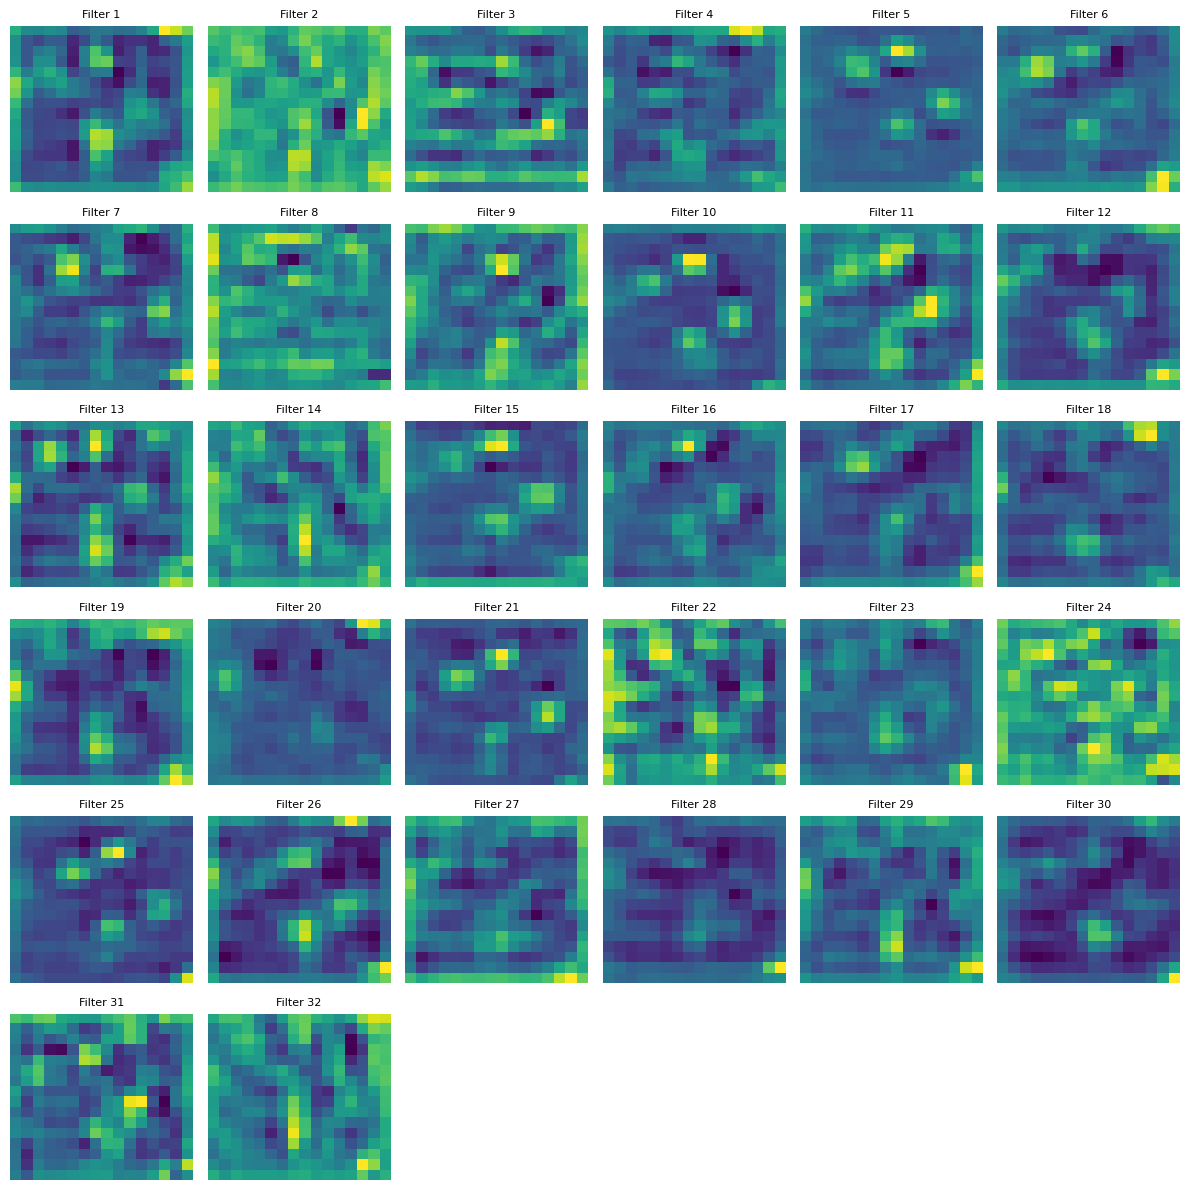

In [99]:
import matplotlib.pyplot as plt

def plot_all_layer_activations(activations, layer_names, max_cols=None, save_filename=None):
    # Determine the maximum number of filters across the specified layers
    max_filters = 0
    for layer_name in layer_names:
        if layer_name in activations:
            tensor_shape = activations[layer_name][0].shape
            num_filters = tensor_shape[0] if len(tensor_shape) == 3 else tensor_shape[1]
            if num_filters > max_filters:
                max_filters = num_filters
    max_filters = min(max_filters, max_cols) if max_cols is not None else max_filters
    
    # Create a figure with subplots
    num_layers = len(layer_names)
    fig, axes = plt.subplots(num_layers, max_filters, figsize=(max_filters * 2, num_layers * 2))
    
    for i, layer_name in enumerate(layer_names):
        if layer_name not in activations:
            print(f"No activations found for layer: {layer_name}")
            continue
        
        activation_tensor = activations[layer_name][0].cpu().numpy()
        # Adjust for tensors that are 3D (missing batch dimension)
        if activation_tensor.ndim == 3:
            activation_tensor = activation_tensor[np.newaxis, :]  # Add a batch dimension
        
        num_filters = activation_tensor.shape[1]
        
        for j in range(max_filters):
            ax = axes[i, j] if num_layers > 1 else axes[j]
            if j < num_filters:
                # Plot the activation map for filter j
                ax.imshow(activation_tensor[0, j, :, :], cmap='viridis', aspect='auto')
                ax.set_title(f'{layer_name}\nFilter {j+1}', fontsize=8)
                ax.axis('off')
            else:
                # Hide axes without data
                ax.axis('off')
    
    plt.tight_layout()

    if save_filename:
        plt.savefig(save_filename)
        plt.close() 
    else:
        plt.show()
        plt.show()

layer_names = [
    # 'conv_seqs_0_conv',
    # 'conv_seqs_0_res_block0_conv0',
    # 'conv_seqs_0_res_block0_conv1',
    # 'conv_seqs_0_res_block1_conv0',
    # 'conv_seqs_0_res_block1_conv1',
    'conv_seqs_1_conv',
    # 'conv_seqs_1_res_block0_conv0',
    # 'conv_seqs_1_res_block0_conv1',
    # 'conv_seqs_1_res_block1_conv0',
    # 'conv_seqs_1_res_block1_conv1',
    # 'conv_seqs_2_conv',
    # 'conv_seqs_2_res_block0_conv0',
    # 'conv_seqs_2_res_block0_conv1',
    # 'conv_seqs_2_res_block1_conv0',
    'conv_seqs_2_res_block1_conv1',
    # 'max_pool2d'
]


for i, observation in enumerate(observations):
    # Run your data through the model
    observation = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)
    activations = {}
    output = model(observation)
    plot_layer_activations_dynamic_grid(activations, "conv_seqs_2_conv",  save_filename=f"../activation_plot_frames/episode_{i}_plot_later.png")
    # plot_all_layer_activations(activations, layer_names, max_cols=20, save_filename=f"../activation_plot_frames/episode_{i}_plot.png")


In [58]:
def create_gif_from_folder(folder_path, gif_filename):
    # Construct the pattern to match the filenames
    pattern = f"{folder_path}/episode_*_plot.png"
    
    # Use glob to find matching filenames
    filenames = sorted(glob.glob(pattern), key=lambda x: int(x.split('_')[-2]))
    
    # Check if filenames list is not empty
    if not filenames:
        print("No files found matching the pattern. Please check the folder path and naming convention.")
        return
        
    # Create the GIF
    with imageio.get_writer(gif_filename, mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
    
    print(f"GIF created successfully: {gif_filename}")

# Example usage:
folder_path = "../activation_plot_frames"  # Adjust this path as needed
gif_filename = "activation_visualization.gif"  # Name of the output GIF file
create_gif_from_folder(folder_path, gif_filename)


No files found matching the pattern. Please check the folder path and naming convention.


In [ ]:
for name, param in model.named_parameters():
    print(f"Parameter name: {name}, shape: {param.size()}")

Parameter name: conv_seqs.0.conv.weight, shape: torch.Size([16, 3, 3, 3])
Parameter name: conv_seqs.0.conv.bias, shape: torch.Size([16])
Parameter name: conv_seqs.0.res_block0.conv0.weight, shape: torch.Size([16, 16, 3, 3])
Parameter name: conv_seqs.0.res_block0.conv0.bias, shape: torch.Size([16])
Parameter name: conv_seqs.0.res_block0.conv1.weight, shape: torch.Size([16, 16, 3, 3])
Parameter name: conv_seqs.0.res_block0.conv1.bias, shape: torch.Size([16])
Parameter name: conv_seqs.0.res_block1.conv0.weight, shape: torch.Size([16, 16, 3, 3])
Parameter name: conv_seqs.0.res_block1.conv0.bias, shape: torch.Size([16])
Parameter name: conv_seqs.0.res_block1.conv1.weight, shape: torch.Size([16, 16, 3, 3])
Parameter name: conv_seqs.0.res_block1.conv1.bias, shape: torch.Size([16])
Parameter name: conv_seqs.1.conv.weight, shape: torch.Size([32, 16, 3, 3])
Parameter name: conv_seqs.1.conv.bias, shape: torch.Size([32])
Parameter name: conv_seqs.1.res_block0.conv0.weight, shape: torch.Size([32, 3

In [125]:
folder_path = "../modified_env_images/*"
filenames = glob.glob(folder_path)
for file in filenames:
    activations = {}
    observation = read_modified_image(file)
    # plot_heist_observation(observation)
    output = model(observation)
    plot_layer_activations_dynamic_grid(activations, "conv_seqs_2_conv",  save_filename=f"../activation_plot_frames/activations_{file.split('/')[2]}", observation=observation)

In [115]:
observation = read_modified_image(filenames[0])

In [108]:
model = load_model(env)

In [116]:
model(observation)

(Categorical(logits: torch.Size([1, 15])),
 tensor([[4.9601]], grad_fn=<AddmmBackward0>))

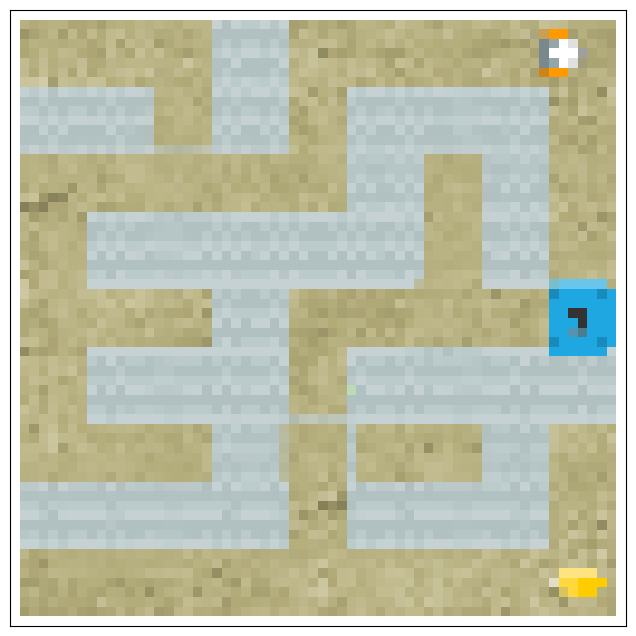

In [85]:
plot_heist_observation(observation)